In [50]:
import numpy as np 
import pandas as pd
import json
import glob

#path = "./events/events_England.json" 
#with open(path) as f:
#    data = json.load(f)
dfs = []
for file in glob.glob('./events/*.json'):
    with open(file) as f:
        json_data = pd.json_normalize(json.loads(f.read()))
        json_data['site'] = file.rsplit("/", 1)[-1]
    dfs.append(json_data)
data = pd.concat(dfs)

train = pd.DataFrame(data)

path2 = "players.json" 

with open(path2) as f:
    play = json.load(f)

players = pd.DataFrame(play)




pd.unique(train['subEventName'])
shots = train[train['subEventName'] == 'Shot']

shots_model = pd.DataFrame(columns=["Goal","X","Y"], dtype=object)

for i,shot in shots.iterrows():
    
    
    shots_model.at[i,'Header'] = 0
    for tag in shot['tags']:
        if tag['id'] == 403:
            shots_model.at[i,'Header'] = 1
    
    
    #take distance from center of goal at y = 50, x position of goal is always 100
    shots_model.at[i,'X'] = 100-shot['positions'][0]['x']
    shots_model.at[i,'Y'] = shot['positions'][0]['y']
    shots_model.at[i,'C'] = abs(shot['positions'][0]['y'] - 50)
        
    #distance in meters
        
    x = shots_model.at[i,'X']* 105/100
    y = shots_model.at[i,'C']* 65/100
    shots_model.at[i,'Distance'] = np.sqrt(x**2 + y**2)
        
    angle = np.arctan(7.32 * x / (x**2 + y**2 - (7.32/2)**2))
        
    if angle < 0:
        angle = np.pi + angle
        
    shots_model.at[i,'Angle'] = angle
        
    #goal check
    shots_model.at[i,'Goal'] = 0
    shots_model.at[i,'GoalB'] = bin(0)
    shots_model.at[i,'Counter Attack'] = 0
    shots_model.at[i, 'Blocked'] = 0
    shots_model.at[i, 'Right Foot'] = 0
    shots_model.at[i,'wyId'] = shot['playerId']
    
    if shot['matchPeriod'] == '1H':
        shots_model.at[i, 'First Half'] = 1
    
    else:
        shots_model.at[i,'First Half'] = 0
        
    for tags in shot['tags']:
        if tags['id'] == 101:
            shots_model.at[i,'Goal'] = 1
            shots_model.at[i,'GoalB'] = bin(1)
            
        if tags['id'] == 1901:
            shots_model.at[i, 'Counter Attack'] = 1
        
        if tags['id'] == 2101:
            shots_model.at[i, 'Blocked'] = 1
        
        if tags['id'] == 402:
            shots_model.at[i, 'Right Foot'] = 1
            
            
        
shots_model['angle_degrees'] = shots_model['Angle'] * 180 / np.pi

shots_model = shots_model.merge(players, left_on = 'wyId' , right_on = 'wyId')

for i,shot in shots_model.iterrows():
    shots_model.at[i, 'strong foot'] = 0
    
    if shot['Right Foot'] == 1:
        if shot['foot'] == 'right':
            shots_model.at[i, 'strong foot'] = 1
    
    elif shot['Right Foot'] == 0:
        if shot['foot'] == 'left':
            shots_model.at[i, 'strong foot'] = 1

In [51]:
shots_model.drop(['passportArea', 'firstName','middleName', 'lastName',
                  'birthDate','role', 'birthArea', 'foot', 'shortName', 
                  'currentNationalTeamId', 'currentTeamId'], axis = 1, inplace = True)

In [52]:
shots_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41843 entries, 0 to 41842
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Goal            41843 non-null  object 
 1   X               41843 non-null  object 
 2   Y               41843 non-null  object 
 3   Header          41843 non-null  float64
 4   C               41843 non-null  float64
 5   Distance        41843 non-null  float64
 6   Angle           41843 non-null  float64
 7   GoalB           41843 non-null  object 
 8   Counter Attack  41843 non-null  float64
 9   Blocked         41843 non-null  float64
 10  Right Foot      41843 non-null  float64
 11  wyId            41843 non-null  float64
 12  First Half      41843 non-null  float64
 13  angle_degrees   41843 non-null  float64
 14  weight          41843 non-null  int64  
 15  height          41843 non-null  int64  
 16  strong foot     41843 non-null  float64
dtypes: float64(11), int64(2), objec

In [53]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = shots_model[['Distance', 'angle_degrees']]#
y = shots_model[['GoalB','Goal']]

X = StandardScaler().fit_transform(X)
X_train, X_test, y_train_BI, y_test_BI = train_test_split(X,y, train_size=0.8)

y_train_int = y_train_BI['Goal']
y_train = y_train_BI['GoalB']
y_test_int = y_test_BI['Goal']
y_test = y_test_BI['GoalB']

print(X_train.shape), print(y_train.shape)
print(X_test.shape), print(y_test.shape)
print(type(y_train_int.iloc[0]), type(y_test_int.iloc[0]))
#X_train, X_rem, y_train, y_rem = train_test_split(X,y, train_size=0.75)
#X_valid, X_test, y_valid, y_test = train_test_split(X_rem,y_rem, test_size=0.5)
#print(X_train.shape), print(y_train.shape)
#print(X_valid.shape), print(y_valid.shape)
#print(X_test.shape), print(y_test.shape)

(33474, 2)
(33474,)
(8369, 2)
(8369,)
<class 'int'> <class 'int'>


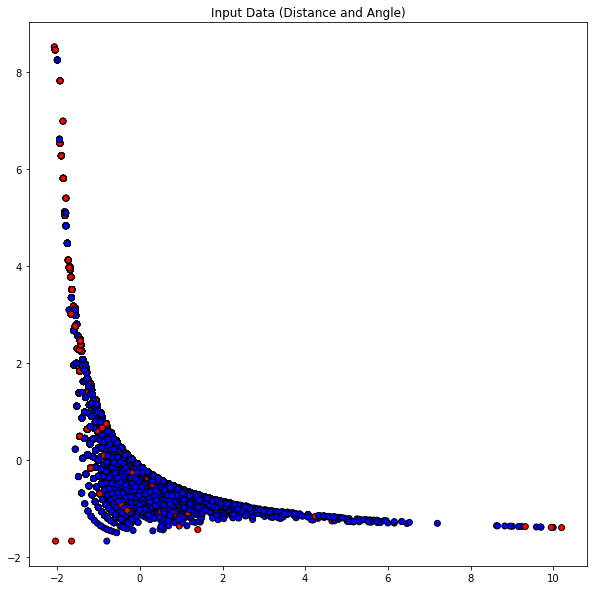

Nearest Neighbors 0.8838570916477476


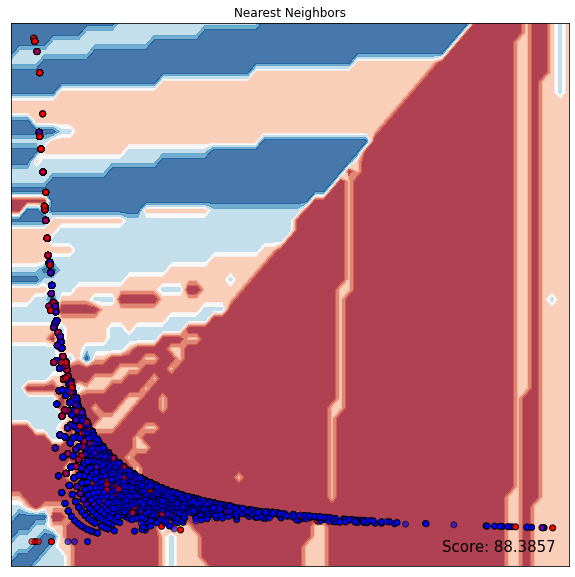

Linear SVM 0.8989126538415582


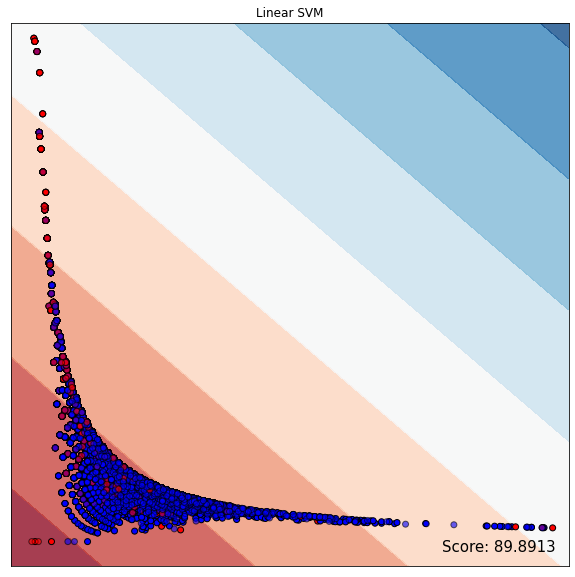

RBF SVM 0.9016608913848727


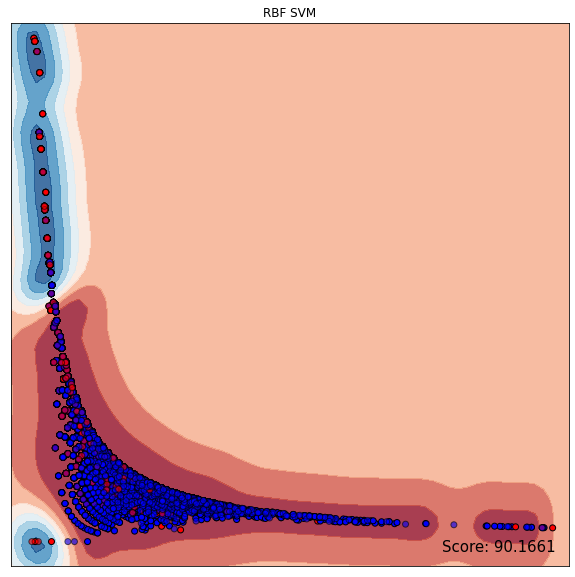

Decision Tree 0.9021388457402318


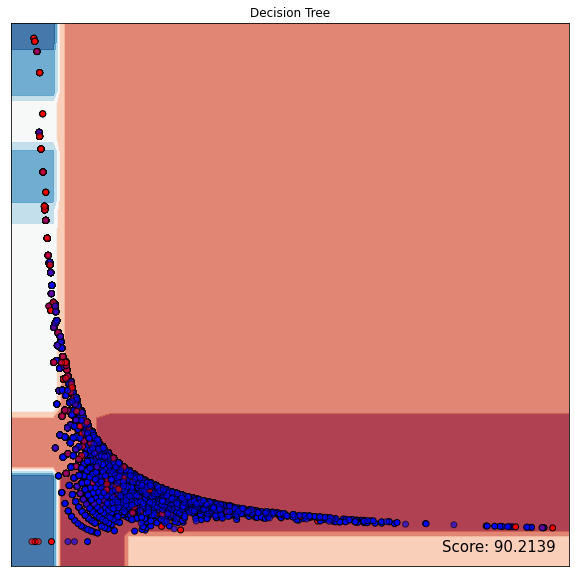

Random Forest 0.9017803799737125


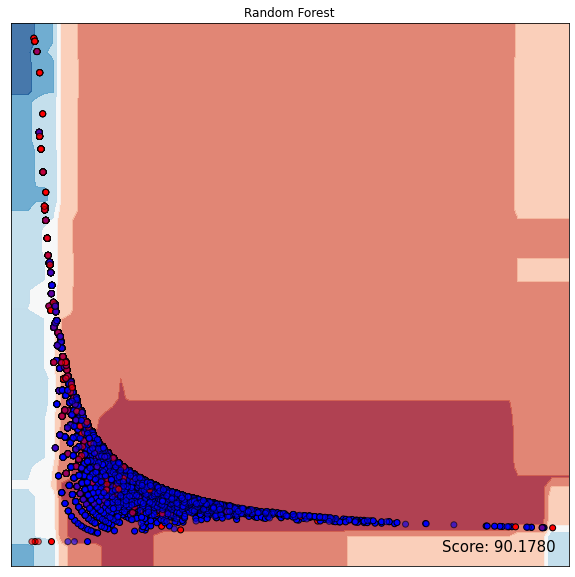

Neural Net 0.9013024256183535


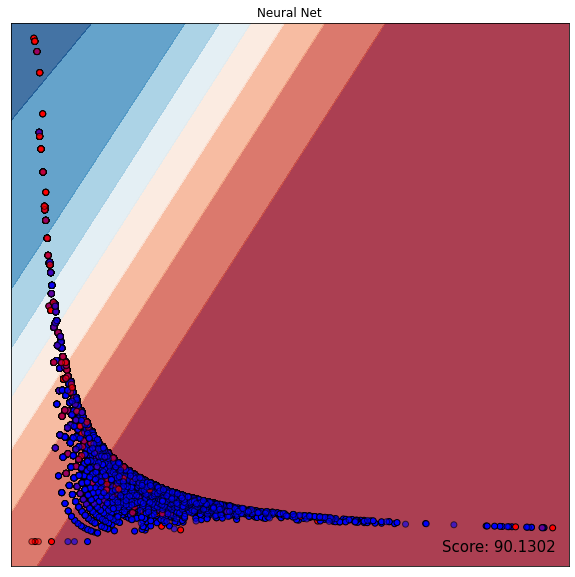

AdaBoost 0.9018998685625523


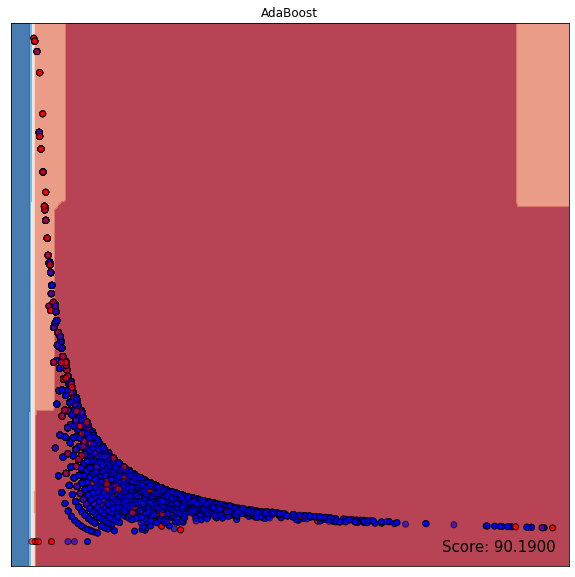

Naive Bayes 0.8845740231807863


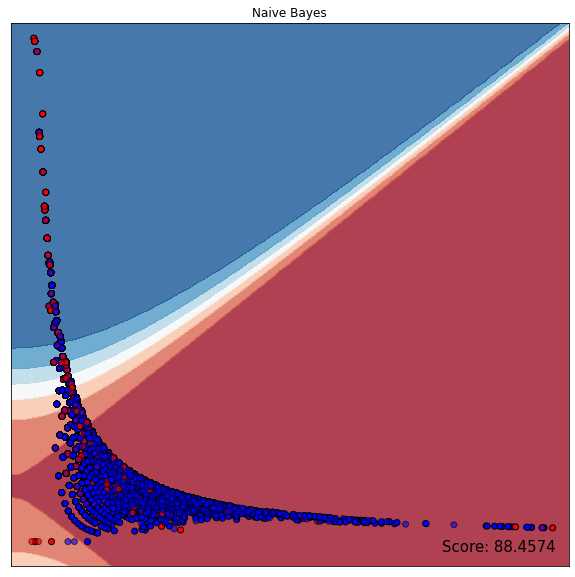

QuadraticDiscriminantAnalysis 0.888756123790178


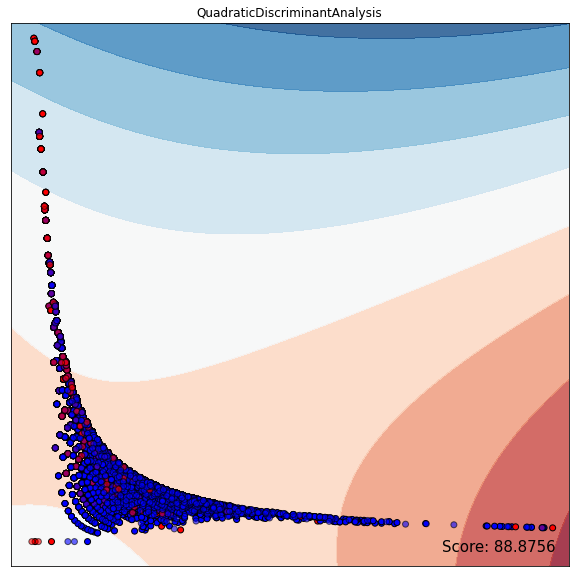

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QuadraticDiscriminantAnalysis",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

h = 0.2


#X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8)
#print(X_train.shape), print(y_train.shape)
#print(X_test.shape), print(y_test.shape)

x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# just plot the dataset first
cm = plt.cm.RdBu
cm_bright = ListedColormap(["#0000FF", "#FF0000"])
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
ax.set_title('Input Data (Distance and Angle)')

ax.scatter(X_train[:, 0], X_train[:, 1], c = y_train_int, cmap=cm_bright, edgecolors="k")
plt.savefig('./image/InputData.jpg')
plt.show()

for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    print(name, score)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot()
    ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train_int, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(X_test[:, 0],X_test[:, 1],c=y_test_int,cmap=cm_bright,edgecolors="k",alpha=0.6,)
    ax.set_title(name)

    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    
    ax.text(
        xx.max() - 0.3,
        yy.min() + 0.3,
        ("Score: %.4f" % (score*100)).lstrip("0"),
        size=15,
        horizontalalignment="right",
    )
    plt.savefig('./image/' + name + '_4.jpg')
    plt.show()